In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output, display, Math

In [ ]:
from keras.datasets import fashion_mnist

# Про dataset `fashion-mnist`

Fashion-MNIST — це набір зображень статей Zalando, що складається з навчального набору з 60 000 прикладів і тестового набору з 10 000 прикладів. Кожен приклад являє собою зображення в градаціях сірого 28x28, пов'язане з міткою з 10 класів:

| Мітка | Опис        | Переклад         |
|-------|-------------|------------------|
| 0     | T-shirt/top | Футболка/сорочка |
| 1     | Trouser     | Штани            |
| 2     | Pullover    | Светр            |
| 3     | Dress       | Плаття           |
| 4     | Coat        | Пальто           |
| 5     | Sandal      | Сандалі          |
| 6     | Shirt       | Сорочка          |
| 7     | Sneaker     | Кросовки         |
| 8     | Bag         | Сумка            |
| 9     | Ankle boot  | Чоботи           |

# Константи

In [ ]:
class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}
input_shape = (28, 28, 1)

# Підготовка навчального та тестового наборів

In [ ]:
# Завантажуємо датасет і розділимо його на навчальну та тестову вибірки.
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

# Нормалізуємо значення пікселів, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.
x_train, x_test = x_train / 255.0, x_test / 255.0

# Побудова архітектури нейронної мережі (моделі)


## Деякий опис використовуваних шарів

```python
keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28, 28, 1))
```

Тут вказано 32 фільтри з ядрами 3х3 пікселя кожен. Потім, параметр `padding='same'` означає, що вихідна карта ознак на кожному каналі має бути тією самою розмірністю, що й вихідне зображення, тобто 28х28 елементів. Фактично, це означає додавання значень на кордонах двовимірних даних (загалом нулів), щоб центр ядра фільтра міг розміщуватися над граничними елементами:

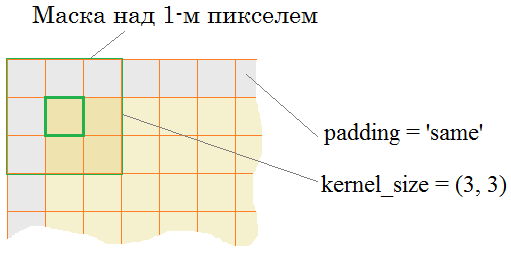

Останні два параметри - функція активації ReLu і формат вхідних даних у вигляді зображень 28х28 пікселів з одним колірним каналом (градації сірого).

Наступний шар відповідно до концепції `CNN` має укрупнювати масштаб отриманих ознак. Для цього найчастіше використовується операція `MaxPooling`:


```python
keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
```

Тут `pool_size` - розмір вікна, в якому обирається максимальне значення; strides - крок сканування за координатами площини; `padding='valid'`` - не додавати нульових значень на кордонах (відповідно рамка не зміщується за межі поля ознак); `data_format`` - формат вхідних даних:

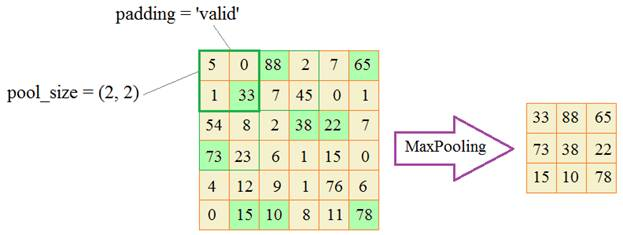

In [ ]:
# Побудова архітектури моделі
keras.utils.set_random_seed(42)


def build_model(dropout_rate):
    model = keras.Sequential()

    model.add(
        layers.Conv2D(
            32, (3, 3), padding="same", activation="relu", input_shape=(28, 28, 1)
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(10, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4, ema_momentum=0.9),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

# Гіперпараметри



In [ ]:
dropout_rate = 0.25
batch_size = 64
epochs = 20

# Створення моделі

In [ ]:
model = build_model(dropout_rate)
model.summary()

# Навчання моделі

Використаэмо колбек ранньої зупинки [EarlyStopping](https://keras.io/api/callbacks/early_stopping/):

```python
early_stopping_callback = EarlyStopping(monitor='val_accuracy', 
                                        patience=2, mode='max', min_delta=0.01, baseline=0.92)
```
1. Для ранньої зупинки будемо моніторити `monitor='val_accuracy'` точність (accuracy) на валідаційній вибірці.
2. Параметр `patience=5`, означає, що якщо точність на валідаційній вибірці не збільшиться протягом 5 останніх епох, навчання буде зупинено.
3. Параметр `mode='max'`  означає, що ми хочемо досягти максимального значення метрики (точності) перед зупинкою навчання.
4. Параметр `min_delta=0.01` означає, що метрика має збільшитися хоча б на 0.01, щоб вважатися поліпшенням.
5. Параметр `baseline=0.92` означає, що ми чекаємо, коли точність на валідаційній вибірці досягне або перевищить 0.92, щоб зупинити навчання.



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.0001,
    patience=10,
    mode="min",
    baseline=0.93,
    restore_best_weights=False,
)


# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(256).prefetch(1)


# Навчання моделі
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    callbacks=[early_stopping],
    batch_size=batch_size,
    validation_data=(x_test, y_test),
)

# Оцінка моделі на тестовому наборі даних
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"\nТочність на тестовому наборі: {test_accuracy:.2f}")

## Візуалізація кривих навчання

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(history.history["val_loss"], label="Validation Loss", marker="o", color="r")
ax1.plot(history.history["loss"], label="Loss", color="r", alpha=0.5)
ax1.set_ylabel("Loss Function", color="b")
ax1.tick_params(axis="y", labelcolor="b")

ax2 = ax1.twinx()

ax2.plot(
    history.history["val_accuracy"], label="Validation Accuracy", marker="o", color="b"
)
ax2.plot(history.history["accuracy"], label="Accuracy", color="b", alpha=0.5)

for i, acc in enumerate(history.history["val_accuracy"]):
    ax2.annotate(
        f"{acc:.2f}",
        (i, acc),
        textcoords="offset points",
        xytext=(0, -15),
        ha="center",
        c="b",
        fontsize=6,
    )
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy", color="r")
ax2.tick_params(axis="y", labelcolor="r")
ax1.grid(True, linestyle="--")

ax1.legend(loc="upper left")
ax2.legend(loc="lower right")

plt.title("Криві навчання")

plt.show()

На кривих спостегрігається деяке перенавчання.

# Перевірка результатів

In [ ]:
predictions = model.predict(x_test)

In [ ]:
number_of_images = 40
f, ax = plt.subplots(5, 8, figsize=(16, 10))
f.subplots_adjust(hspace=0.5, wspace=0.3)

f.suptitle("Візуалізація передбачень моделі для датасета", fontsize=14)


for axes_index, sample_index in enumerate(np.random.choice(10000, number_of_images)):
    prob = predictions[sample_index]
    img, true_label = x_test[sample_index], y_test[sample_index]
    predicted_label = np.argmax(prob)
    if predicted_label == true_label:
        color = "blue"
        cmap = "Blues"
    else:
        color = "red"
        cmap = "Reds"

    ax[axes_index // 8, axes_index % 8].imshow(img, cmap=cmap)
    ax[axes_index // 8, axes_index % 8].axis("off")
    ax[axes_index // 8, axes_index % 8].set_title(
        f"Pred: {predicted_label} - {class_labels.get(predicted_label)}\nTrue: {true_label} - {class_labels.get(true_label)}\nProb: {prob.max()*100:.0f} %",
        fontsize=8,
        color=color,
    )

    inset_ax = f.add_axes(
        [
            ax[axes_index // 8, axes_index % 8].get_position().x1,
            ax[axes_index // 8, axes_index % 8].get_position().y0,
            0.02,
            ax[axes_index // 8, axes_index % 8].get_position().height,
        ]
    )

    classes = np.arange(len(class_labels))
    inset_ax.scatter(
        np.ones(10) * 0.5,
        classes,
        s=20,
        c=prob,
        cmap="Reds",
        marker="o",
        edgecolor=(0.5, 0.5, 0.5, 0.2),
        linewidths=1,
    )
    inset_ax.set_xlim(0, 1)
    inset_ax.set_ylim(-1, 10)
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.axis("off")
    for i, p in enumerate(prob):
        if p > 0.1:
            inset_ax.text(0.7, i, f"{i}", fontsize=8, verticalalignment="center")

plt.show()

На візуалізації представлені зображення із тестової вибірки. В синіх тонах - розпізнані правильно, в червоних - неправильно. Праворуч наведена шкала (фактично це нейрони вихідного шару), де колір пропорційний "ймовірності" розпізнавання, також праворуч наведені мітки класів (номер нейрона), якщо їх ймовірність більше 10 %, щоб можна побачити принаймні, де наша модель мала "сумніви", і врешті решт якому класу вона давала перевагу. Можливо, це в подальших дослідженнях натякне на спосіб покращення точності.

# Висновки

В результаті використання згорткової нейронної мережі вдалось досягти точності 0.92. В попередньому завдання для повнозєязної нейронної мережі вдалось досягти точності лише 0.89. 

На рандомно вибраних сорока зображенняхвдається часто побачити такі вибірки, де не правильно розпізнано всього два зображення, ба навіть можна знайти де неправильно розпізнане всього одне зображення, як на представленому зображенні.

Отже, згорткові нейронні мережі є більш ефективними для обробки зображень.